## Importación de librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos


In [2]:
%pip install pandas pyarrow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

# Cargar el archivo .parquet
df_yellow = pd.read_parquet('../data/yellow_tripdata_2023-09.parquet')

# Mostrar las primeras filas
df_yellow.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-09-01 00:15:37,2023-09-01 00:20:21,1.0,0.80,1.0,N,163,230,2,6.5,3.5,0.5,0.00,0.0,1.0,11.50,2.5,0.00
1,2,2023-09-01 00:18:40,2023-09-01 00:30:28,2.0,2.34,1.0,N,236,233,1,14.2,1.0,0.5,2.00,0.0,1.0,21.20,2.5,0.00
2,2,2023-09-01 00:35:01,2023-09-01 00:39:04,1.0,1.62,1.0,N,162,236,1,8.6,1.0,0.5,2.00,0.0,1.0,15.60,2.5,0.00
3,2,2023-09-01 00:45:45,2023-09-01 00:47:37,1.0,0.74,1.0,N,141,229,1,5.1,1.0,0.5,1.00,0.0,1.0,11.10,2.5,0.00
4,2,2023-09-01 00:01:23,2023-09-01 00:38:05,1.0,9.85,1.0,N,138,230,1,45.0,6.0,0.5,17.02,0.0,1.0,73.77,2.5,1.75


In [ ]:
df_yellow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2846722 entries, 0 to 2846721
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [5]:
# La columna store_and_fwd_flag no es de utilidad para el análisis. Por tanto la elimino. Lo mismo con vendorID, que indica el proveedor del servicio de pago del taxi
df_yellow.drop(columns = ['store_and_fwd_flag', 'VendorID'], inplace = True)

En primer lugar elimino las filas que contengan algun null

In [6]:
df_yellow = df_yellow.dropna()
print(len(df_yellow), 'entradas')

2706497 entradas


Elimino todas las filas que contengan algún valor negativo, ya que no tendría sentido.

In [7]:
# Eliminar filas con valores negativos en cualquier columna
df_yellow = df_yellow[(df_yellow.select_dtypes(include=['number']) >= 0).all(axis=1)]
print(len(df_yellow), 'entradas')

2677246 entradas


Elimino las filas con LocationID 264 y 265, ya que en el df de las zonas de Taxi TLC no aparece a que ubicación corresponden

In [8]:
df_yellow = df_yellow[((df_yellow['PULocationID']<= 263) & (df_yellow['PULocationID']>= 1))
                      & ((df_yellow['DOLocationID']<= 263) & (df_yellow['DOLocationID']>= 1))]
df_yellow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2630062 entries, 0 to 2706496
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int32         
 6   DOLocationID           int32         
 7   payment_type           int64         
 8   fare_amount            float64       
 9   extra                  float64       
 10  mta_tax                float64       
 11  tip_amount             float64       
 12  tolls_amount           float64       
 13  improvement_surcharge  float64       
 14  total_amount           float64       
 15  congestion_surcharge   float64       
 16  Airport_fee            float64       
dtypes: datetime64[us](2), float64(12), int32(2), int64(1)
memory usage: 34

Según la info del dataset descargada de Kaggle, mta_tax es de 0.50$ o 0$ en función de la tarifa. Por tanto, se van a eliminar las filas que contienen otros valores en esta columna.
 El improvement surchage asumimos que solo puede ser 1(True) o 0(False). Por lo tanto, se eliminan las filas que contienen otros valores.

In [9]:
print(f'Improvement surchage: {df_yellow["improvement_surcharge"].value_counts()}')
print(f'mta_tax: {df_yellow["mta_tax"].value_counts()}')

Improvement surchage: improvement_surcharge
1.0    2629323
0.0        447
0.3        292
Name: count, dtype: int64
mta_tax: mta_tax
0.50    2609069
0.00      20935
0.05         52
1.05          4
4.00          2
Name: count, dtype: int64


In [10]:
df_yellow = df_yellow[(df_yellow['mta_tax'].isin([0, 0.5])) & (df_yellow['improvement_surcharge'].isin([0, 1]))]
df_yellow['mta_tax'] = df_yellow['mta_tax'].astype('bool')
df_yellow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2629712 entries, 0 to 2706496
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   tpep_dropoff_datetime  datetime64[us]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int32         
 6   DOLocationID           int32         
 7   payment_type           int64         
 8   fare_amount            float64       
 9   extra                  float64       
 10  mta_tax                bool          
 11  tip_amount             float64       
 12  tolls_amount           float64       
 13  improvement_surcharge  float64       
 14  total_amount           float64       
 15  congestion_surcharge   float64       
 16  Airport_fee            float64       
dtypes: bool(1), datetime64[us](2), float64(11), int32(2), int64(1)
memory 

In [11]:
# Improvement surcharge es 1 en casi el 100% de los casos, por tanto se elimina esa variable ya que no aportará nada al análisis, y se elimina tambien extra porque no se tiene explicación correcta de qué representa esa variable, por lo tanto no la podemos interpretar
df_yellow.drop(columns = ['improvement_surcharge', 'extra'], inplace = True)

In [12]:
df_yellow.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,tip_amount,tolls_amount,total_amount,congestion_surcharge,Airport_fee
0,2023-09-01 00:15:37,2023-09-01 00:20:21,1.0,0.80,1.0,163,230,2,6.5,True,0.00,0.0,11.50,2.5,0.00
1,2023-09-01 00:18:40,2023-09-01 00:30:28,2.0,2.34,1.0,236,233,1,14.2,True,2.00,0.0,21.20,2.5,0.00
2,2023-09-01 00:35:01,2023-09-01 00:39:04,1.0,1.62,1.0,162,236,1,8.6,True,2.00,0.0,15.60,2.5,0.00
3,2023-09-01 00:45:45,2023-09-01 00:47:37,1.0,0.74,1.0,141,229,1,5.1,True,1.00,0.0,11.10,2.5,0.00
4,2023-09-01 00:01:23,2023-09-01 00:38:05,1.0,9.85,1.0,138,230,1,45.0,True,17.02,0.0,73.77,2.5,1.75


In [13]:
# A partir de las columnas iniciales podemos extraer nuevas features útiles para el modelo, como la duración del viaje y velocidad media

df_yellow['pickup_DoW'] =df_yellow['tpep_pickup_datetime'].dt.day_of_week
df_yellow['pickup_DoW_name'] =df_yellow['tpep_pickup_datetime'].dt.day_name()
df_yellow['pickup_Timestamp'] = df_yellow['tpep_pickup_datetime'].dt.time
df_yellow['pickup_Time'] = df_yellow['tpep_pickup_datetime'].dt.hour
df_yellow['trip_duration'] = (df_yellow['tpep_dropoff_datetime'] - df_yellow['tpep_pickup_datetime']).dt.total_seconds()
df_yellow['avg_speed(km/h)'] = (df_yellow['trip_distance'] / (df_yellow['trip_duration']/3600))



df_yellow

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,...,tolls_amount,total_amount,congestion_surcharge,Airport_fee,pickup_DoW,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h)
0,2023-09-01 00:15:37,2023-09-01 00:20:21,1.0,0.80,1.0,163,230,2,6.5,True,...,0.00,11.50,2.5,0.00,4,Friday,00:15:37,0,284.0,10.140845
1,2023-09-01 00:18:40,2023-09-01 00:30:28,2.0,2.34,1.0,236,233,1,14.2,True,...,0.00,21.20,2.5,0.00,4,Friday,00:18:40,0,708.0,11.898305
2,2023-09-01 00:35:01,2023-09-01 00:39:04,1.0,1.62,1.0,162,236,1,8.6,True,...,0.00,15.60,2.5,0.00,4,Friday,00:35:01,0,243.0,24.000000
3,2023-09-01 00:45:45,2023-09-01 00:47:37,1.0,0.74,1.0,141,229,1,5.1,True,...,0.00,11.10,2.5,0.00,4,Friday,00:45:45,0,112.0,23.785714
4,2023-09-01 00:01:23,2023-09-01 00:38:05,1.0,9.85,1.0,138,230,1,45.0,True,...,0.00,73.77,2.5,1.75,4,Friday,00:01:23,0,2202.0,16.103542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706492,2023-09-30 23:30:43,2023-09-30 23:39:15,2.0,1.50,1.0,163,236,2,8.6,True,...,0.00,13.60,2.5,0.00,5,Saturday,23:30:43,23,512.0,10.546875
2706493,2023-09-30 23:57:35,2023-10-01 00:31:52,1.0,8.90,1.0,230,17,1,35.2,True,...,0.00,48.25,2.5,0.00,5,Saturday,23:57:35,23,2057.0,15.576082
2706494,2023-09-30 23:08:07,2023-09-30 23:16:03,1.0,2.30,1.0,262,233,1,12.1,True,...,0.00,18.47,2.5,0.00,5,Saturday,23:08:07,23,476.0,17.394958
2706495,2023-09-30 23:27:31,2023-09-30 23:46:24,1.0,3.44,1.0,161,261,1,19.8,True,...,0.00,31.00,2.5,0.00,5,Saturday,23:27:31,23,1133.0,10.930274


En la info del dataset descargada de Kaggle, se especifica que no se incluyen las propinas pagadas en cash. Por lo tanto, a continuación se eliminan todos los viajes pagados en cash, ya que generarían errores en el modelo, al no estar contabilizada la propina

In [14]:
print(f'Num. de filas: {len(df_yellow)}')
df_yellow = df_yellow[df_yellow['payment_type'] != 2]
print(f'Num. de filas despues de eliminar viajes pagados en cash: {len(df_yellow)}')

Num. de filas: 2629712
Num. de filas despues de eliminar viajes pagados en cash: 2189839


A continuación voy a eliminar los viajes que tengan duraciones anómalas, ya que se considerarán errores. Se define como valor erróneo cualquier viaje que dure menos de 3 minutos o más de 1,5 horas. 1,5 horas es una duración elevada para un viaje en taxi, pero al ser Nueva York una ciudad con mucho tráfico, es posible que algunos viajes duren más de lo esperado, por eso se ha puesto un límite superior tan alto.

In [15]:
print(f'Num. de filas: {len(df_yellow)}')
df_yellow = df_yellow[(df_yellow['trip_duration'] > 180) & (df_yellow['trip_duration'] < 5400)]
print(f'Num. de filas despues de eliminar viajes de duración extraña: {len(df_yellow)}')

Num. de filas: 2189839
Num. de filas despues de eliminar viajes de duración extraña: 2114791


(array([862826., 620325., 301501., 145679.,  79329.,  46753.,  26918.,
         16135.,   9734.,   5591.]),
 array([ 181. ,  702.8, 1224.6, 1746.4, 2268.2, 2790. , 3311.8, 3833.6,
        4355.4, 4877.2, 5399. ]),
 <BarContainer object of 10 artists>)

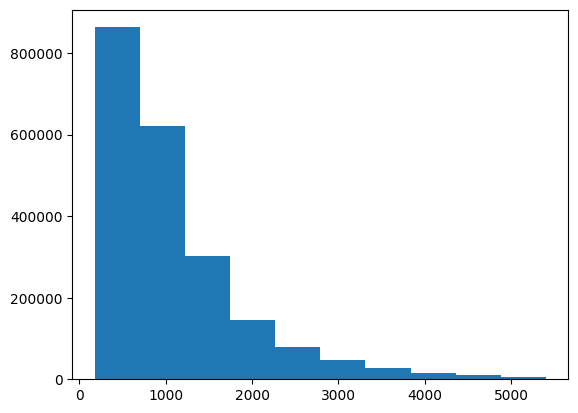

In [16]:
plt.hist(df_yellow['trip_duration'])

In [17]:
print('Sin propina: ', len(df_yellow['tip_amount'][df_yellow['tip_amount'] == 0]))
print('Propina < 5$ : ', len(df_yellow['tip_amount'][df_yellow['tip_amount'] <5]) - len(df_yellow['tip_amount'][df_yellow['tip_amount'] == 0]))
print('Propina < 10$ : ', len(df_yellow['tip_amount'][df_yellow['tip_amount'] <10]) - len(df_yellow['tip_amount'][df_yellow['tip_amount'] <5]))
print('Propina < 20$ : ', len(df_yellow['tip_amount'][df_yellow['tip_amount'] <20]) - len(df_yellow['tip_amount'][df_yellow['tip_amount'] <10]))
print('Propina < 50$ : ', len(df_yellow['tip_amount'][df_yellow['tip_amount'] <50]) - len(df_yellow['tip_amount'][df_yellow['tip_amount'] <20]))
print('Propina > 50$ : ', len(df_yellow['tip_amount'][df_yellow['tip_amount'] >50]))
print(f'Propina máxima recibida: {df_yellow["tip_amount"].max()} $')


Sin propina:  123279
Propina < 5$ :  1415455
Propina < 10$ :  374380
Propina < 20$ :  184191
Propina < 50$ :  17123
Propina > 50$ :  268
Propina máxima recibida: 411.1 $


In [18]:
df_yellow.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,...,tolls_amount,total_amount,congestion_surcharge,Airport_fee,pickup_DoW,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h)
1,2023-09-01 00:18:40,2023-09-01 00:30:28,2.0,2.34,1.0,236,233,1,14.2,True,...,0.0,21.20,2.5,0.00,4,Friday,00:18:40,0,708.0,11.898305
2,2023-09-01 00:35:01,2023-09-01 00:39:04,1.0,1.62,1.0,162,236,1,8.6,True,...,0.0,15.60,2.5,0.00,4,Friday,00:35:01,0,243.0,24.000000
4,2023-09-01 00:01:23,2023-09-01 00:38:05,1.0,9.85,1.0,138,230,1,45.0,True,...,0.0,73.77,2.5,1.75,4,Friday,00:01:23,0,2202.0,16.103542
6,2023-09-01 00:51:50,2023-09-01 01:10:21,0.0,10.90,1.0,93,255,1,41.5,True,...,0.0,47.00,0.0,0.00,4,Friday,00:51:50,0,1111.0,35.319532
7,2023-09-01 00:01:04,2023-09-01 00:18:36,1.0,3.90,1.0,140,7,1,20.5,True,...,0.0,31.85,2.5,0.00,4,Friday,00:01:04,0,1052.0,13.346008


In [19]:
# Paso la columna distance de millas a km. La conversión es 1 milla = 1,609 km
df_yellow['trip_distance'] = df_yellow['trip_distance'] * 1.609
df_yellow.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,...,tolls_amount,total_amount,congestion_surcharge,Airport_fee,pickup_DoW,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h)
1,2023-09-01 00:18:40,2023-09-01 00:30:28,2.0,3.76506,1.0,236,233,1,14.2,True,...,0.0,21.20,2.5,0.00,4,Friday,00:18:40,0,708.0,11.898305
2,2023-09-01 00:35:01,2023-09-01 00:39:04,1.0,2.60658,1.0,162,236,1,8.6,True,...,0.0,15.60,2.5,0.00,4,Friday,00:35:01,0,243.0,24.000000
4,2023-09-01 00:01:23,2023-09-01 00:38:05,1.0,15.84865,1.0,138,230,1,45.0,True,...,0.0,73.77,2.5,1.75,4,Friday,00:01:23,0,2202.0,16.103542
6,2023-09-01 00:51:50,2023-09-01 01:10:21,0.0,17.53810,1.0,93,255,1,41.5,True,...,0.0,47.00,0.0,0.00,4,Friday,00:51:50,0,1111.0,35.319532
7,2023-09-01 00:01:04,2023-09-01 00:18:36,1.0,6.27510,1.0,140,7,1,20.5,True,...,0.0,31.85,2.5,0.00,4,Friday,00:01:04,0,1052.0,13.346008


In [20]:
df_yellow['trip_distance'].describe()

count    2.114791e+06
mean     5.952127e+00
std      9.052295e+01
min      0.000000e+00
25%      1.785990e+00
50%      2.960560e+00
75%      5.599320e+00
max      7.478375e+04
Name: trip_distance, dtype: float64

In [21]:
# Solo se van a considerar para el análisis los viajes cuya distancia esté entre 1 y 100 km
print(f'Num. de filas: {len(df_yellow)}')
df_yellow = df_yellow[(df_yellow['trip_distance'] >= 1) & (df_yellow['trip_distance'] <= 100)]
print(f'Num. de filas despues de eliminar viajes de distancia extraña: {len(df_yellow)}')

Num. de filas: 2114791
Num. de filas despues de eliminar viajes de distancia extraña: 1986237


In [22]:
# Elimino las columnas que no se van a usar

df_yellow.drop(columns = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'total_amount'], inplace = True)
df_yellow.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,tip_amount,tolls_amount,congestion_surcharge,Airport_fee,pickup_DoW,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h)
1,2.0,3.76506,1.0,236,233,1,14.2,True,2.00,0.0,2.5,0.00,4,Friday,00:18:40,0,708.0,11.898305
2,1.0,2.60658,1.0,162,236,1,8.6,True,2.00,0.0,2.5,0.00,4,Friday,00:35:01,0,243.0,24.000000
4,1.0,15.84865,1.0,138,230,1,45.0,True,17.02,0.0,2.5,1.75,4,Friday,00:01:23,0,2202.0,16.103542
6,0.0,17.53810,1.0,93,255,1,41.5,True,3.00,0.0,0.0,0.00,4,Friday,00:51:50,0,1111.0,35.319532
7,1.0,6.27510,1.0,140,7,1,20.5,True,6.35,0.0,2.5,0.00,4,Friday,00:01:04,0,1052.0,13.346008


El siguiente paso es realizar un describe para identificar posibles datos erróneos que haya que eliminar

In [23]:
round(df_yellow.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
passenger_count,1986237.0,1.35,0.87,0.00,1.00,1.00,1.00,8.00
trip_distance,1986237.0,5.96,7.17,1.01,1.96,3.15,5.94,82.77
RatecodeID,1986237.0,1.75,8.21,1.00,1.00,1.00,1.00,99.00
PULocationID,1986237.0,164.40,63.24,1.00,132.00,161.00,233.00,263.00
DOLocationID,1986237.0,162.97,69.41,1.00,113.00,162.00,234.00,263.00
payment_type,1986237.0,1.03,0.28,1.00,1.00,1.00,1.00,4.00
fare_amount,1986237.0,21.18,16.91,0.00,10.70,14.90,24.00,750.00
tip_amount,1986237.0,4.61,4.08,0.00,2.38,3.50,5.24,411.10
tolls_amount,1986237.0,0.67,2.25,0.00,0.00,0.00,0.00,96.94
congestion_surcharge,1986237.0,2.35,0.60,0.00,2.50,2.50,2.50,2.50


In [24]:
# En el describe se observa que la máxima fare amount es 187000 $, lo cual no es normal. Por tanto se acota tambien esta variable a valores entre 3 y 3000$
print(f'Num. de filas: {len(df_yellow)}')
df_yellow = df_yellow[(df_yellow['fare_amount'] >= 3) & (df_yellow['fare_amount'] <= 3000)]
print(f'Num. de filas despues de eliminar viajes de precio extraño: {len(df_yellow)}')

Num. de filas: 1986237
Num. de filas despues de eliminar viajes de precio extraño: 1986131


In [25]:
# Tambien se observa que hay viajes con 0 pasajeros. Se eliminan estas entradas
df_yellow = df_yellow[df_yellow['passenger_count']>= 1]

In [26]:
df_yellow['RatecodeID'].value_counts()

RatecodeID
1.0     1854582
2.0       81380
99.0      13995
3.0        6366
5.0        2601
4.0         373
Name: count, dtype: int64

In [ ]:
# Se sustituyen los 99 por 6
df_yellow['RatecodeID'].replace(99, 6, inplace = True)
df_yellow['RatecodeID'].value_counts()


/var/folders/7j/lfytp_zn1p3gd9v7k7jvgk340000gn/T/ipykernel_45371/291485599.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_yellow['RatecodeID'].replace(99, 6, inplace = True)


RatecodeID
1.0    1854582
2.0      81380
6.0      13995
3.0       6366
5.0       2601
4.0        373
Name: count, dtype: int64

Número de viajes con velocidad media mayor a 100km/h:  18


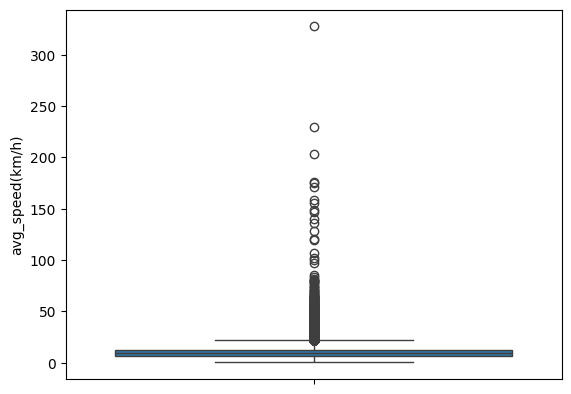

In [28]:
# En el describe se observan tambien velocidades medias que son imposibles. 
sns.boxplot(df_yellow['avg_speed(km/h)'])
print('Número de viajes con velocidad media mayor a 100km/h: ', len(df_yellow['avg_speed(km/h)'][df_yellow['avg_speed(km/h)']> 100]))

In [29]:
# Se encontraron 18 viajes con una velocidad media mayor a 100km/h. Estos viajes se consideraran errores, por lo tanto serán eliminados
df_yellow = df_yellow[df_yellow['avg_speed(km/h)'] <= 100]

In [30]:
round(df_yellow.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
passenger_count,1959279.0,1.36,0.86,1.00,1.00,1.00,1.00,8.00
trip_distance,1959279.0,5.98,7.18,1.01,1.96,3.15,5.95,82.77
RatecodeID,1959279.0,1.09,0.50,1.00,1.00,1.00,1.00,6.00
PULocationID,1959279.0,164.36,63.23,1.00,132.00,161.00,233.00,263.00
DOLocationID,1959279.0,162.95,69.42,1.00,113.00,162.00,234.00,263.00
payment_type,1959279.0,1.03,0.28,1.00,1.00,1.00,1.00,4.00
fare_amount,1959279.0,21.21,16.93,3.00,10.70,14.90,24.00,750.00
tip_amount,1959279.0,4.62,4.08,0.00,2.38,3.50,5.25,411.10
tolls_amount,1959279.0,0.67,2.25,0.00,0.00,0.00,0.00,96.94
congestion_surcharge,1959279.0,2.35,0.60,0.00,2.50,2.50,2.50,2.50


## Transformación de features


A la variable passenger_count se le va a aplicar una transformación para intentar simplificar los datos y reducir el desbalanceo, ya que presenta una distribución altamente desigual. Las opciones consideradas fueron:  

- Transformación binaria: Convertir la variable en una binaria que tome el valor 0 para viajes individuales (un solo pasajero) y 1 para viajes grupales (dos o más pasajeros).    
- Agrupación limitada: Limitar los valores de passenger_count a un máximo de 3, dejando los valores originales para 1, 2, y 3, y agrupando a 3 todos los casos con más de tres pasajeros
- Agrupación limitada hasta 4 pasajeros

In [ ]:
df_yellow['passenger_count'].value_counts()

passenger_count
1.0    1525275
2.0     293165
3.0      64760
4.0      32003
5.0      26499
6.0      17569
7.0          5
8.0          3
Name: count, dtype: int64

Para escoger cual es la mejor opción, se va a realizar el test de Kruskal- Wallis entre la transformación binaria, la agrupación limitada hasta 3 pasajeros y hasta 4 pasajeros y la variable original, y se seleccionará la que presente mejor resultado.  
El test de Kruskal-Wallis es una prueba estadística no paramétrica que permite comparar las distribuciones de tres o más grupos independientes para determinar si sus medianas son significativamente diferentes.


In [32]:
# Transformación 1: Binaria (0 = individual, 1 = grupal)
df_yellow['passenger_binary'] = (df_yellow['passenger_count'] > 1).astype(int)

# Transformación 2: Limitar a 1, 2, 3+
df_yellow['passenger_limited'] = df_yellow['passenger_count'].apply(lambda x: x if x <= 3 else 3)

# Transformación 3: Limitar a 1, 2, 3, 4+
df_yellow['passenger_limited2'] = df_yellow['passenger_count'].apply(lambda x: x if x <= 4 else 4)

# Correlaciones con tip_amount
correlations = {
    'Original': df_yellow['passenger_count'].corr(df_yellow['tip_amount']),
    'Binary': df_yellow['passenger_binary'].corr(df_yellow['tip_amount']),
    'Limited': df_yellow['passenger_limited'].corr(df_yellow['tip_amount']),
    'Limited2': df_yellow['passenger_limited2'].corr(df_yellow['tip_amount'])
}
print(correlations)

{'Original': 0.024255427742026516, 'Binary': 0.04722226366086912, 'Limited': 0.03481688336026535, 'Limited2': 0.029275288547040746}


In [33]:
from scipy.stats import kruskal

# Grupos para la transformación binaria
binary_groups = [df_yellow[df_yellow['passenger_binary'] == i]['tip_amount'] for i in [0, 1]]

# Grupos para la transformación limitada
limited_groups = [df_yellow[df_yellow['passenger_limited'] == i]['tip_amount'] for i in [1, 2, 3]]

# Grupos para la transformación limitada 2
limited_groups2 = [df_yellow[df_yellow['passenger_limited2'] == i]['tip_amount'] for i in [1, 2, 3, 4]]

# Prueba de Kruskal-Wallis
binary_test = kruskal(*binary_groups)
limited_test = kruskal(*limited_groups)
limited_test2 = kruskal(*limited_groups2)

print(f"Kruskal-Wallis Test for Binary Transformation: H-statistic={binary_test.statistic}, p-value={binary_test.pvalue}")
print(f"Kruskal-Wallis Test for Limited Transformation: H-statistic={limited_test.statistic}, p-value={limited_test.pvalue}")
print(f"Kruskal-Wallis Test for Limited Transformation 2: H-statistic={limited_test2.statistic}, p-value={limited_test2.pvalue}")

Kruskal-Wallis Test for Binary Transformation: H-statistic=2288.1275661895897, p-value=0.0
Kruskal-Wallis Test for Limited Transformation: H-statistic=3013.0515067179062, p-value=0.0
Kruskal-Wallis Test for Limited Transformation 2: H-statistic=3018.123850559452, p-value=0.0


En los 3 casos el p-value es 0, lo que indica que hay grandes diferencias entre las distribuciones de los distintos grupos en los 3 casos. La transformacion escogida va a ser la agrupacion limitada a 3+ pasajeros, ya que tiene un resultado prácticamente igual que limitada a 4+, pero los datos quedan algo mejor balanceados, y simplifica la variable

In [34]:
df_yellow['passenger_count'] = df_yellow['passenger_count'].apply(lambda x: x if x <= 3 else 3)
df_yellow = df_yellow.drop(columns = ['passenger_binary', 'passenger_limited', 'passenger_limited2'])

También se realiza una transformación de la variable tolls_amount para convertirla en la proporción de precio de peajes respecto a la tarifa(fare_amount). 
 Esto se hace porque el costo en peajes tiene un significado relativo, es decir, un peaje de por ejemplo 5$ no es percibido igual en un viaje de 10$ que en uno de 50$. De esta manera se podrá aportar más información al modelo, ya que ña proporción de peajes podría correlacionarse con el comportamiento del cliente al dejar propinas, ya que podría percibir que los peajes aumentan los costos del viaje.

In [35]:
df_yellow['tolls_percentage'] = df_yellow['tolls_amount'] / df_yellow['fare_amount']
df_yellow.drop(columns = ['tolls_amount'], inplace = True)

In [36]:
# Mover la columna target al final
column_to_move = 'tip_amount'
df_yellow = df_yellow[[col for col in df_yellow if col != column_to_move] + [column_to_move]]

In [37]:
# Elimino columnas que se decide no utilizar en el modelo
df_yellow = df_yellow.drop(columns=['RatecodeID', 'payment_type', 'mta_tax', 'pickup_Timestamp', 'pickup_DoW_name'])
df_yellow.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1959279 entries, 1 to 2706496
Data columns (total 13 columns):
 #   Column                Dtype  
---  ------                -----  
 0   passenger_count       float64
 1   trip_distance         float64
 2   PULocationID          int32  
 3   DOLocationID          int32  
 4   fare_amount           float64
 5   congestion_surcharge  float64
 6   Airport_fee           float64
 7   pickup_DoW            int32  
 8   pickup_Time           int32  
 9   trip_duration         float64
 10  avg_speed(km/h)       float64
 11  tolls_percentage      float64
 12  tip_amount            float64
dtypes: float64(9), int32(4)
memory usage: 179.4 MB


In [37]:
# Guardo el df con los datos preprocesados

# df_yellow.to_csv('./data/df_yellowtaxi_cleaned.csv', sep = ',')